## 0.0 Imports

In [1]:
import warnings
import re 
import numpy         as np
import pandas        as pd
import seaborn       as sns
import matplotlib.cm as cm
import umap.umap_ as umap

from plotly              import express       as px
from sklearn             import cluster       as c 
from sklearn             import metrics       as m
from sklearn             import ensemble      as en
from sklearn             import manifold      as mn
from sklearn             import mixture       as mx 
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from matplotlib          import pyplot        as plt
from scipy.cluster       import hierarchy     as hc
from sklearn.neighbors   import NearestNeighbors
from sklearn.manifold    import TSNE 
from pandas_profiling    import ProfileReport 
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_14677/3400927134.py:21: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling    import ProfileReport


### 0.1 Helper Functions

### 0.2 Load Dataset

In [2]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding='ISO-8859-1')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1)

In [3]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [5]:
df1.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

### 1.2 Data dimension

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0]))
print( 'Number of cols: {}'.format( df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [10]:
# remove NA
# df1 = df1.dropna( subset=['description', 'customer_id'])
# print('Removed data: {:.2f}'.format(1-(df1.shape[0] / df_raw.shape[0])))

In [11]:
# df1.isna().sum()

In [12]:
# Primeira tentativa em resolver o problema do NA

df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [13]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframa
df1 = pd.merge (df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6 Change dtypes

In [15]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7 Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Atrributes

In [18]:
# central tendecy - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - desvio, padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T 

# concatenate
wew = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
wew.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
wew 

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


##### 1.7.1.1 Numerical Attributes - Investigating

1. Quantidade negativa(pode ser devolução)?
2. Preço unitário igual a zero (pode ser promoção)?

#### 1.7.2 Categorical Attributes

##### Invoice No

In [19]:
# problema: Temos invoice com letras e números
# df1['invoice_no'].astype(int)

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool(re.search( '[0-9]+', x))), :]

print( 'Total number of invoices: {}'.format(len(df_letter_invoices)))
print( 'Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']<0])))

Total number of invoices: 541909
Total number of negative quantity: 10624


##### Stock Code

In [20]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search('^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

##### Description

In [21]:
df1.head()

# Ação: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


##### Country

In [22]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [23]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [24]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()


,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


## 2.0 Filtragem de Variavéis

In [25]:
df2 = df1.copy()
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [26]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [27]:
# Numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map - 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

## 3.0 Feature Engineering

In [28]:
# Feature Ideas:
## Moving Average - 7d, 14d, 30d
## Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
## Average Financial
## Basket Size * Price - Quantidade de preços por cesta


In [29]:
df3 = df2.copy()

### 3.1 Feature Creation

In [30]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 
                    'invoice_date', 'unit_price', 'country'], 
                    axis=1).drop_duplicates(ignore_index=True)

#### 3.1.1 Gross Revenue

In [31]:
# Gross Revenue (faturamento)
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_14677/2279638179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Recency - Day from last purchase

In [32]:
# Recency - Last day purchase
df_recency = df2_purchases.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.3 Quantity of purchased

In [33]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                              .groupby('customer_id')
                                                              .count()
                                                              .reset_index()
                                                              .rename(columns={'invoice_no': 'qtde_invoices'}))

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

#### 3.1.4 Quantity total of items purchased

In [34]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id')
                                                              .sum()
                                                              .reset_index()
                                                              .rename(columns={'quantity': 'qtde_items'}))

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

#### 3.1.5 Quantity of products purchased

In [35]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id')
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns={'stock_code': 'qtde_products'}))

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

#### 3.1.6 Average Ticket Value

In [36]:
# Avg Ticket
df_avg_ticket = (df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id')
                                                                      .mean()
                                                                      .reset_index()
                                                                      .rename(columns={'gross_revenue': 'avg_ticket'}))

df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

#### 3.1.7 Average Recency Days

In [37]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False,False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() #next invoice date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['previous_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

#### 3.1.8 Frequency Purchase

In [38]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                     .groupby('customer_id')
                                                                     .agg( max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                           buy_ = ('invoice_no', 'count'))).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x ['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

#### 3.1.9 Number of Returns

In [39]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

#### 3.1.10 Basket Size - Quantidade de items por cesta (quantity)

- Invoice No = Compra = purchase
- Stock Code = Produto = Product
- Quantity = Item = Item

In [40]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                         .agg( n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('quantity', 'sum'))
                                                                               .reset_index())
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.11 Unique Basket Size - Quantidaade de produtos distintos por compra

In [41]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                           .agg( n_purchase=('invoice_no', 'nunique'),
                                                                                 n_products=('stock_code', 'nunique'))
                                                                            .reset_index())
# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [42]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


## 4.0 EDA (Exploratory Data Analysis)

In [43]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

### 4.1 Uniariate Analysis

Métricas para olharmos

    1. Clusters Coesos - Separados
    2. Métricas
        - Min, Max, Range (dispersão)
        - Média e Mediana
        - Desvio Padrão e Variância
        - Coeficiente de variação (cv)
        - Distribuição

Investigar/Remover
    
    1. Gross Revenue - ok

In [44]:
#profile = ProfileReport(df4)
#profile.to_file('output_v3.html')

#### 4.1.1 Gross Revenue

In [45]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000


In [46]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


#### 4.1.2 Qtde Items

In [47]:
df4[df4['qtde_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


#### 4.1.3 Qtde Products

In [48]:
#df4[df4['customer_id'] == 7838].head()
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
1442,C536543,22355,-2,2016-11-29,0.85,United Kingdom,17841
2037,536557,21495,25,2016-11-29,0.42,United Kingdom,17841
2038,536557,46000R,2,2016-11-29,1.45,United Kingdom,17841
2039,536557,46000S,1,2016-11-29,1.45,United Kingdom,17841


#### 4.1.4 Avg Ticket

In [49]:
#df4[df4['avg_ticket'] == 56157.5]
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


#### 4.1.5 Frequency

In [50]:
#df4[df4['frequency'] == 17]
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850
...,...,...,...,...,...,...,...
86898,C543611,82483,-1,2017-02-08,4.95,United Kingdom,17850
86899,C543611,21874,-1,2017-02-08,1.06,United Kingdom,17850
86900,C543611,71477,-2,2017-02-08,2.75,United Kingdom,17850
86901,C543611,82483,-1,2017-02-08,4.95,United Kingdom,17850


#### 4.1.6 Average Basket Size

In [51]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


### 4.2 Bivariate Analysis

In [52]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

<Figure size 2500x1200 with 0 Axes>

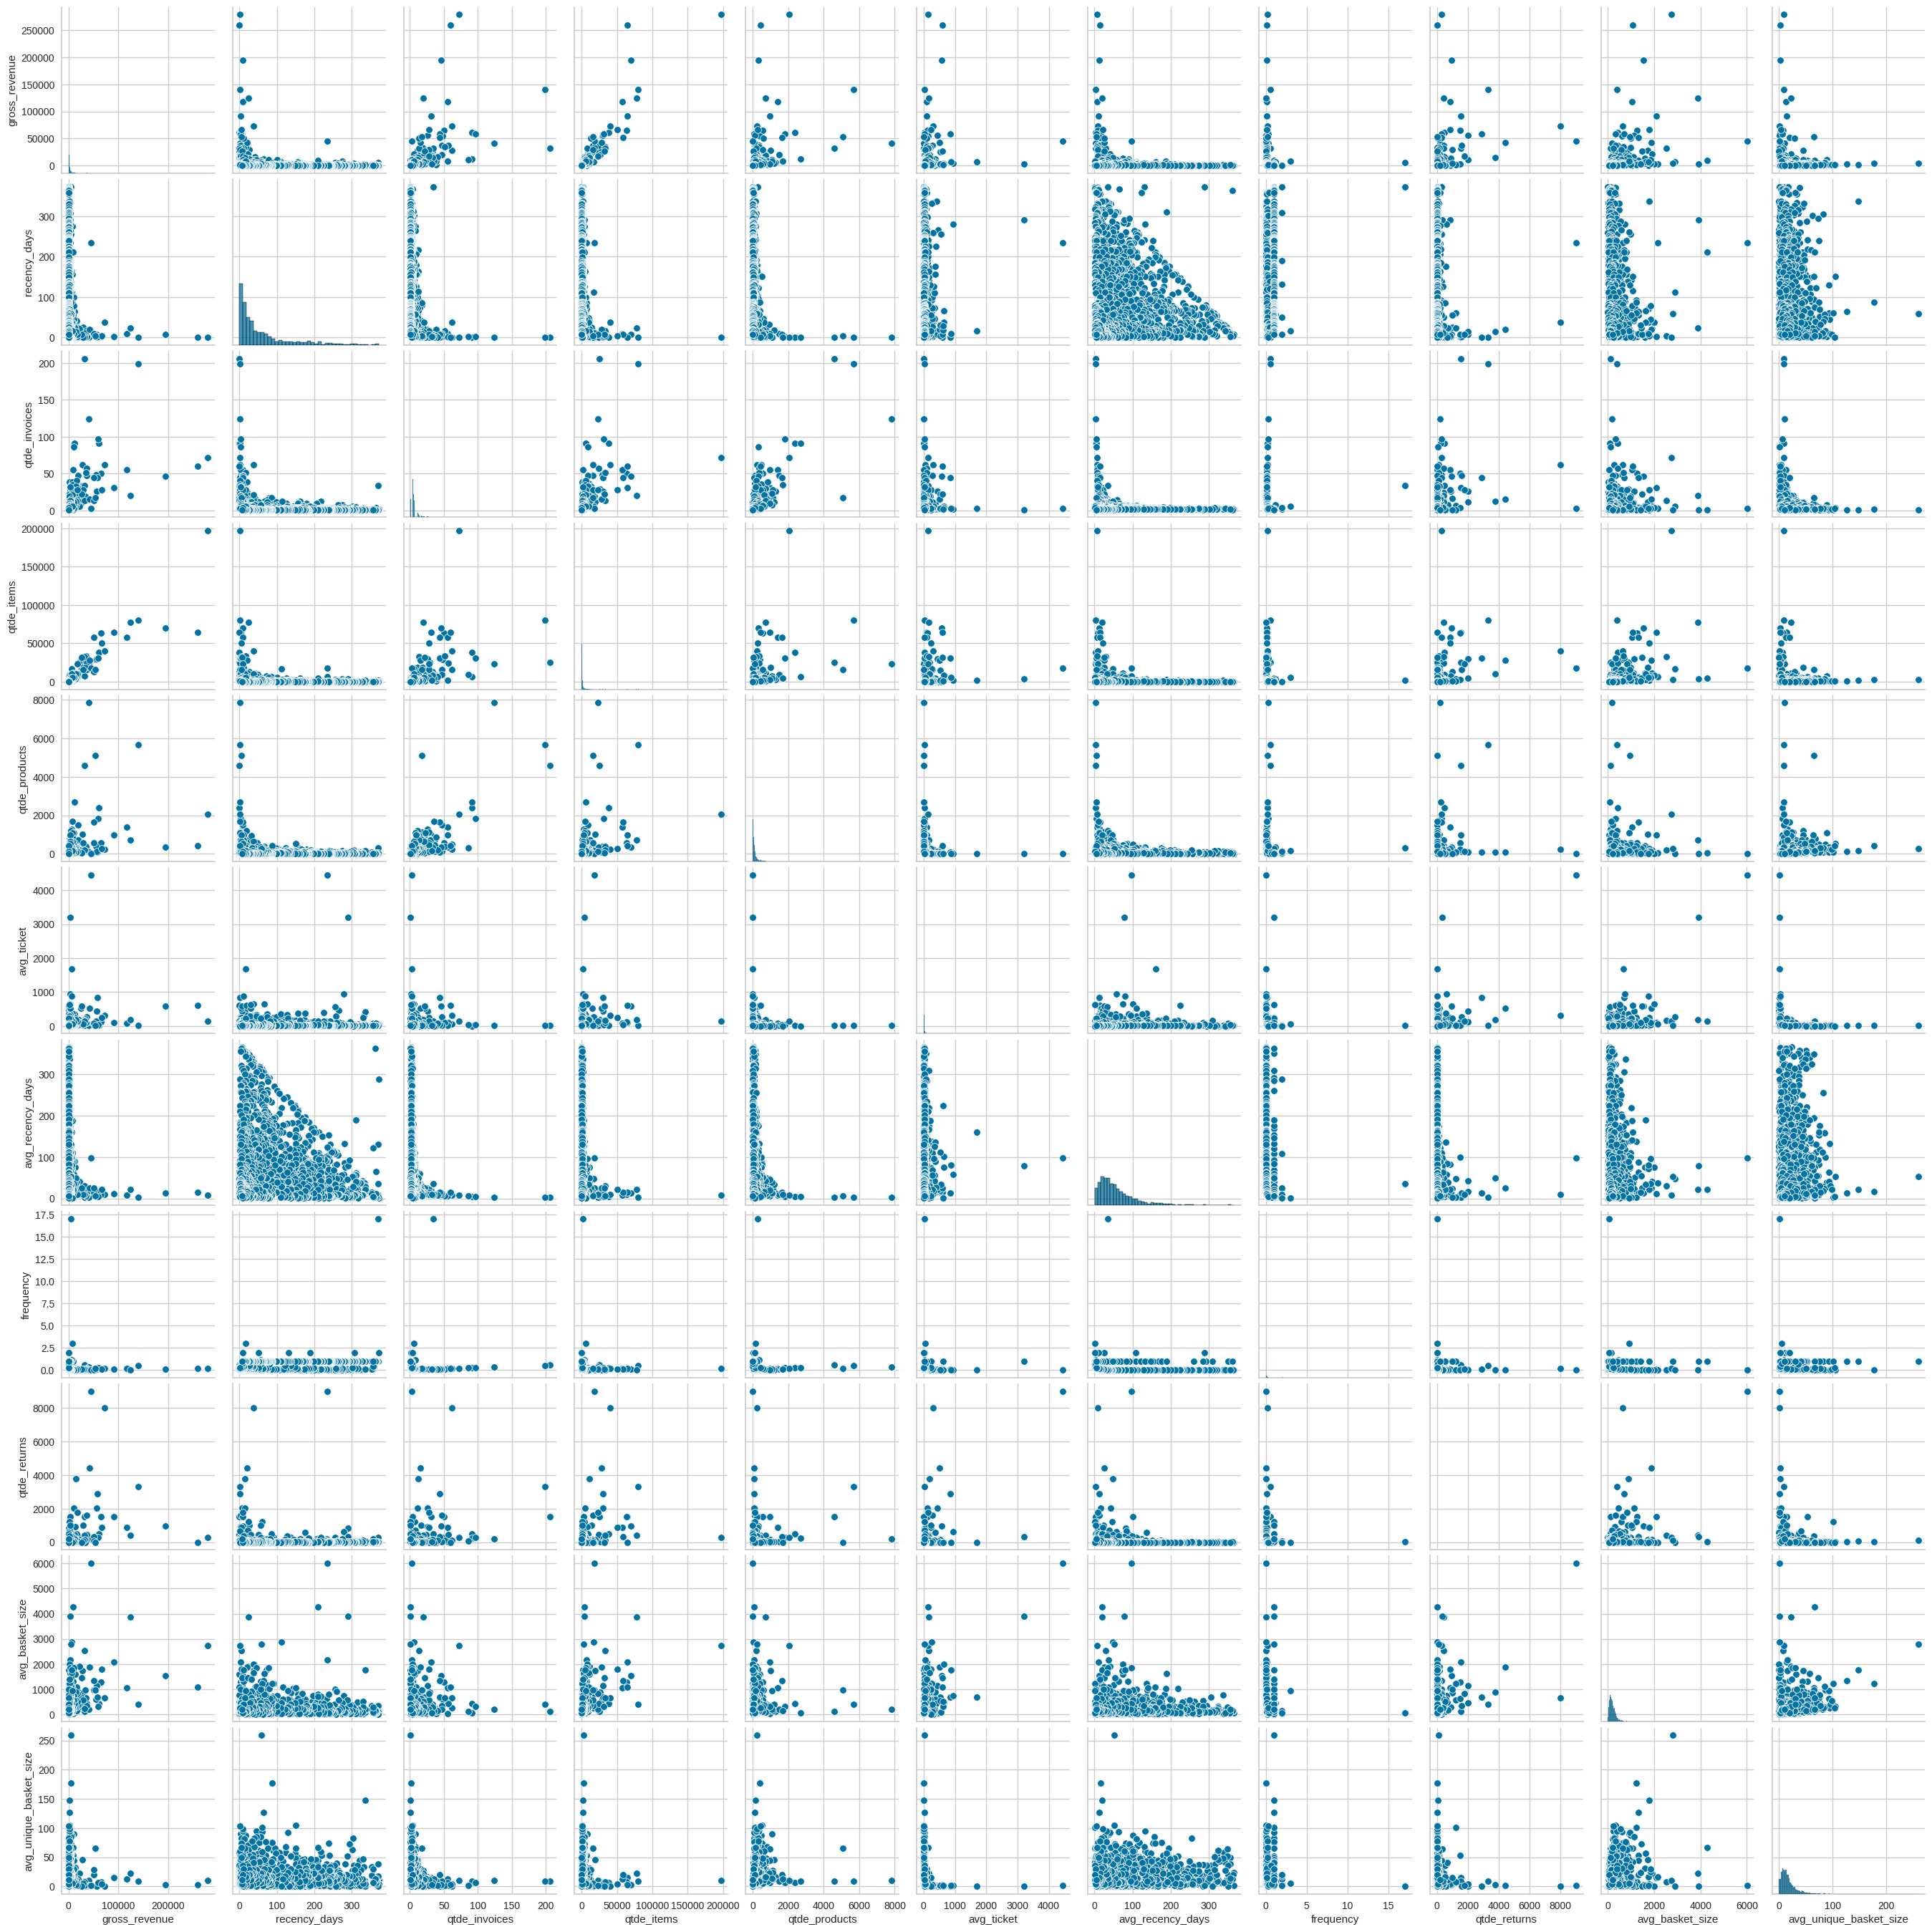

In [53]:
plt.figure(figsize=(25,12))
sns.pairplot(df42)

**Notes**
1. Frequency has low variance
2. Avg Ticket has low variance

### 4.3 Estudo do Espaço

In [54]:
# original dataset
#df43 = df4.drop(columns=['customer_id'], axis=1).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [55]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
#df43['qtde_invoices']          = mm.fit_transform(df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform(df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform(df43[['qtde_products']])
#df43['avg_ticket']             = mm.fit_transform(df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform(df43[['qtde_returns']])
#df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()


#### 4.3.1 PCA

In [56]:
X.shape

(2968, 6)

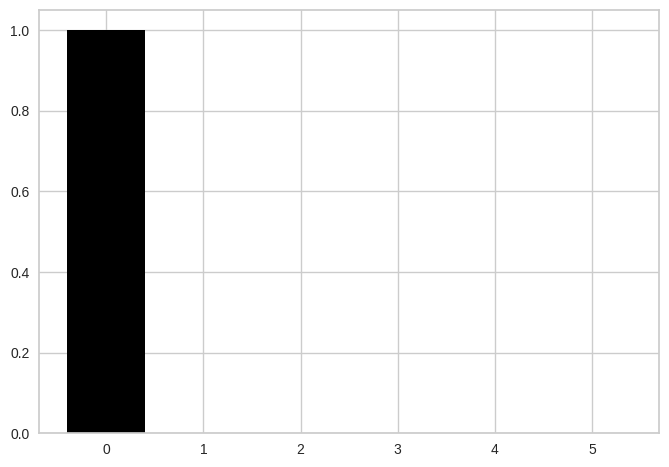

In [57]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

#plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

#pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot: xlabel='0', ylabel='1'>

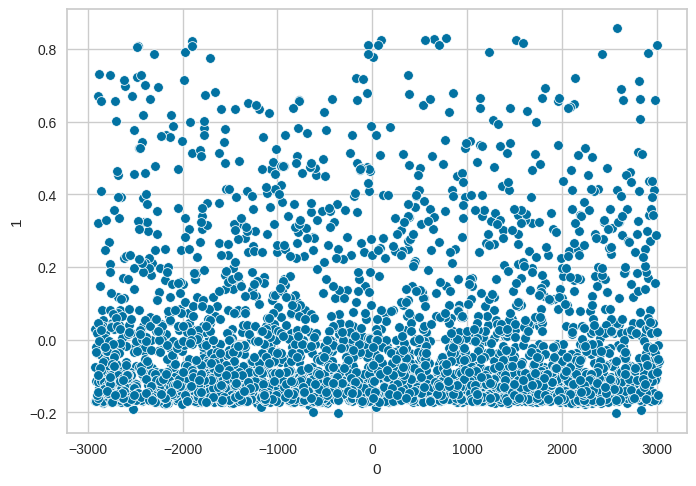

In [58]:
sns.scatterplot(x=0, y=1, data=df_pca)

#### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

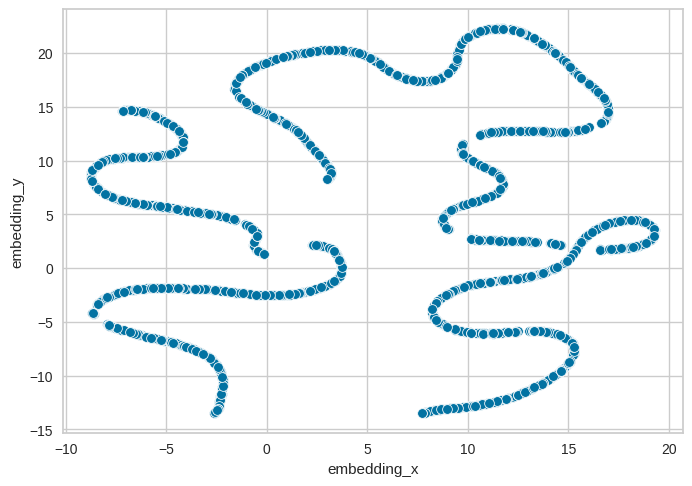

In [59]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

#### 4.3.3 t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

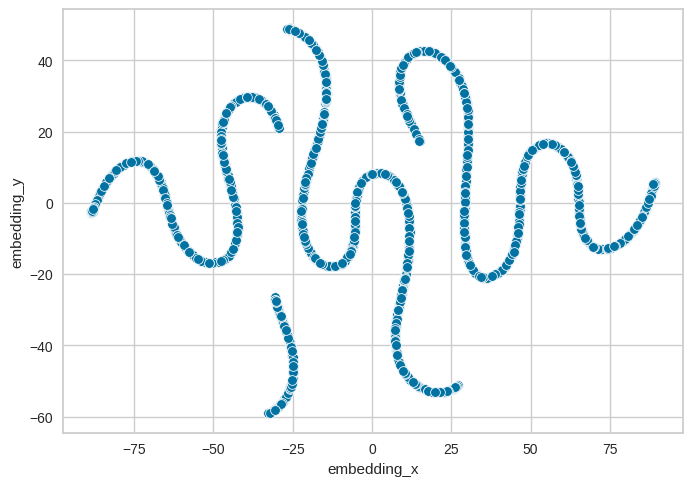

In [60]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot TSNE
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

#### 4.3.4 Tree-Based Embedding

In [61]:
# training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf

#dataframe Leaf

RandomForestRegressor(random_state=42)

In [62]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [63]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2991,2716,3326,3337,2284,3147,3227,3135,3166,3364,...,3186,3172,3176,3059,3044,3121,3187,2826,3356,3326
1,2960,2924,3042,2970,2739,3131,2924,2830,3110,2853,...,2509,2887,2883,2992,3145,3010,2911,2799,2964,2816
2,3632,3608,3587,3411,3570,3660,3634,3548,3679,3614,...,3598,3440,3560,3482,3601,3460,3528,3619,3568,3654
3,1278,1412,1763,1489,2017,1461,2102,1458,1656,1718,...,1877,1719,2026,1881,1936,2246,1467,1196,1988,2105
4,355,715,579,691,146,711,734,689,191,197,...,331,192,584,544,196,156,189,705,707,175


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

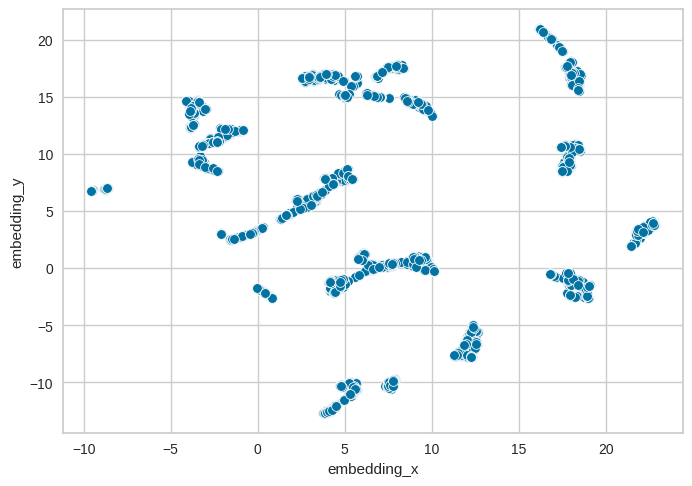

In [64]:
# reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tree)

## 5.0 Data Preparation

Padronização / Normalização ( Standardization ) -> Premissa de que os dados vieram de uma distribuiçã normal

Rescala (Rescale) -> Não tem premissa de que os dados vieram de uma distribuição normal

**Regra do Coração**
1. Distribuiçåo Normal e não possui Outlier -> Standard Scaler - Media e desvio padrao
2. Distribuiçåo Normal e possuí Outlier -> Robust Scaler - Quartis
3. Não distribuição normal -> Min Max Scaler

**Testes de Normalidade**

1. QQ Plot  - Quantile Quantile Plot ( Quatile teorica x Quantile real )
2. KS Teste - Kolgomorov Smirnoff ( Teste de Hipótese ) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição Normal

**Detecção Outlier** 

1. Box Plot -> Pontos são identificados como Outliers
2. IRQ * 2.5 -> Acima desse valor ( Outlier )

Z-Score > 3  -> Outilers

Z-Score < -3 -> Outliers

In [65]:
#df5 = df4.copy()
df5 = df_tree.copy()

### 5.1 Testes

In [62]:
## Fazer o teste com ss e se não apresentar uma normal, utilizar o mm
## Fazer isso para todas as variaveis e conferir com o displot e boxplot a presença de outliers

#mm = pp.MinMaxScaler()
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()


#df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
#df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
#df5['qtde_invoices'] = ss.fit_transform( df5[['qtde_invoices']] )
#df5['qtde_items'] = ss.fit_transform( df5[['qtde_items']] )
#df5['qtde_products'] = ss.fit_transform( df5[['qtde_products']] )
#df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
#df5['avg_recency_days'] = ss.fit_transform( df5[['avg_recency_days']] )
#df5['frequency'] = ss.fit_transform( df5[['frequency']] )
#df5['qtde_returns'] = ss.fit_transform( df5[['qtde_returns']] )
#df5['avg_basket_size'] = ss.fit_transform( df5[['avg_basket_size']] )
#df5['avg_unique_basket_size'] = ss.fit_transform( df5[['avg_unique_basket_size']] )

#variable = 'recency_days'

#### 5.1.1 Teste Gross Revenue

In [66]:
# Dados AS IS
#print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max()))
#sns.displot(df5_aux[variable])

In [67]:
# Dados Normalizados / Rescalados
#print('Min:{} - Max:{}'.format(df5[variable].min(), df5[variable].max()))
#sns.displot(df5[variable])

In [68]:
#sns.boxplot(df5_aux[variable]);

#### 5.1.2 Teste Recency Days

In [69]:
# Dados AS IS
#print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max()))
#sns.displot(df5_aux[variable])

In [70]:
# Dados Normalizados / Rescalados
#print('Min:{} - Max:{}'.format(df5[variable].min(), df5[variable].max()))
#sns.displot(df5[variable])

In [71]:
#sns.boxplot(df5_aux[variable]);

### 5.2 Rescaling

In [72]:
#mm = pp.MinMaxScaler()
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()


#df5['gross_revenue']          = mm.fit_transform( df5[['gross_revenue']] )
#df5['recency_days']           = mm.fit_transform( df5[['recency_days']] )
#df5['qtde_invoices']          = mm.fit_transform( df5[['qtde_invoices']] )
#df5['qtde_items']             = mm.fit_transform( df5[['qtde_items']] )
#df5['qtde_products']          = mm.fit_transform( df5[['qtde_products']] )
#df5['avg_ticket']             = mm.fit_transform( df5[['avg_ticket']] )
#df5['avg_recency_days']       = mm.fit_transform( df5[['avg_recency_days']] )
#df5['frequency']              = mm.fit_transform( df5[['frequency']] )
#df5['qtde_returns']           = mm.fit_transform( df5[['qtde_returns']] )
#df5['avg_basket_size']        = mm.fit_transform( df5[['avg_basket_size']] )
#df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )


## 6.0 Feature Selection

In [73]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [74]:
#df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

## 7.0 Hyperparameter Fine-Tuning

In [75]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()
X.head()

,embedding_x,embedding_y
0,21.462481,1.975596
1,18.213978,-2.484788
2,17.456253,19.114374
3,-1.531421,2.519522
4,6.208858,15.189176


In [76]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange(2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

### 7.1 K-Means

In [77]:
kmeans_list = []
for k in clusters:
    #model definition
    kmeans_model = c.KMeans(n_clusters=k)

    #model training
    kmeans_model.fit(X)

    #model predict
    labels = kmeans_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

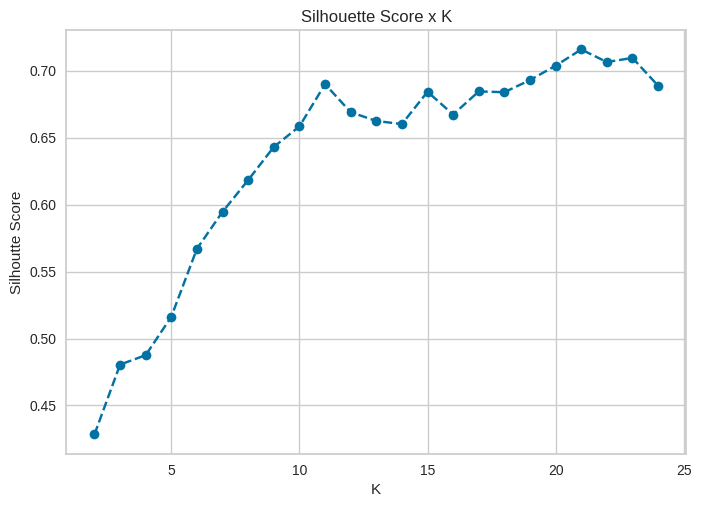

In [78]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhoutte Score');
plt.title('Silhouette Score x K');

### 7.2 GMM - Gaussian Mixture Models

In [79]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

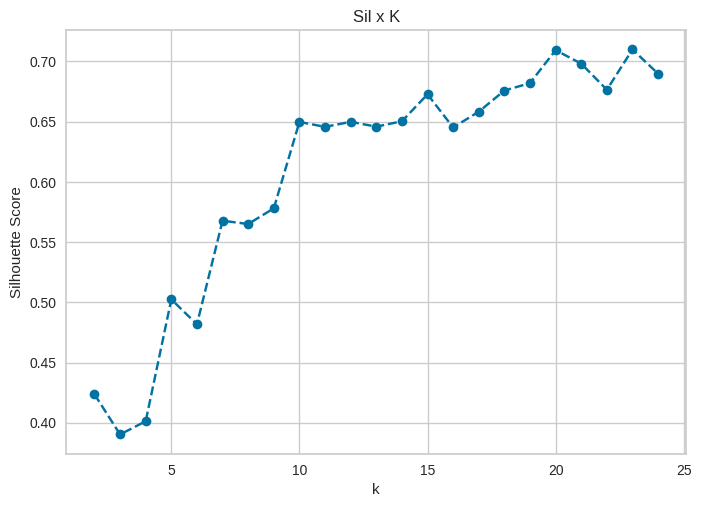

In [80]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

### 7.3 Hierarchical Clustering

In [81]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

In [82]:
#hc.dendrogram(
#    hc_model,
#    leaf_rotation=90,
#    leaf_font_size=8
#)

#plt.plot()

In [83]:
#hc.dendrogram(
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.show()

#### 7.3.1 HClustering Silhoutte Score

In [84]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

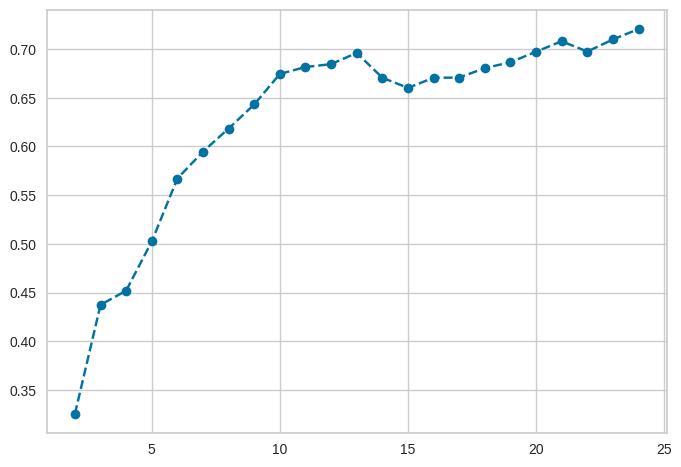

In [85]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

### 7.4 DBased Scan

In [86]:
eps = 2.00
min_samples = 20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
print('Silhoutte Score: {}'.format(sil))
unique_labels = np.unique(labels)
print('Number of Clusters: {}'.format(len(unique_labels)))
print(unique_labels)

Silhoutte Score: 0.6840779781341553
Number of Clusters: 12
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [87]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors(X)

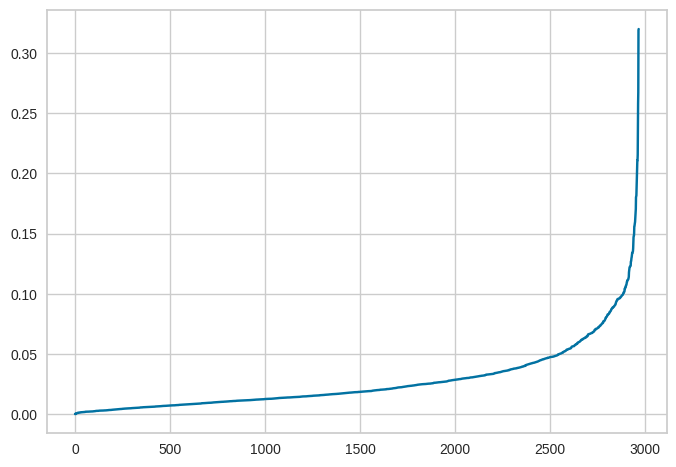

In [88]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

In [93]:
dbscan_list = [ 0.190872, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

### 7.5 Results

In [89]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list} 
#     'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [90]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.428349,0.480570,0.487595,0.516314,0.567106,0.594744,0.618437,0.643172,0.658478,0.690039,0.669165,0.662562,0.660257,0.684398,0.667387,0.684637,0.684062,0.693113,0.703865,0.715986,0.706598,0.709690,0.688901
GMM,0.423775,0.390376,0.401347,0.502491,0.481788,0.567791,0.565037,0.578074,0.649772,0.645700,0.649839,0.645868,0.650330,0.672717,0.645162,0.658271,0.675808,0.682003,0.709357,0.698152,0.676482,0.709916,0.689804
HC,0.325369,0.437441,0.451970,0.502491,0.567106,0.594744,0.618437,0.643172,0.674470,0.681550,0.684523,0.696065,0.670566,0.660157,0.670535,0.670755,0.680456,0.686501,0.697306,0.708045,0.697456,0.709857,0.720576


In [95]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.722958,0.592730,0.561965,0.580615,0.552414,0.551069
GMM,0.042310,-0.016524,0.174489,-0.122952,-0.175530,-0.096229
HC,0.721382,0.570514,0.562887,0.496029,0.515360,0.515740
DBSCAN,0.190872,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.507904,0.519431,0.391971,0.359172,0.328066,0.341061
GMM,-0.004519,0.012877,-0.042206,-0.048131,-0.021595,-0.090880
HC,0.468911,0.498824,0.327713,0.316046,0.328641,0.325372
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


### 7.6 Silhouette Analysis

 For K = 2. Silhouette Score: 0.7213816951267069
 For K = 3. Silhouette Score: 0.570514250543775
 For K = 4. Silhouette Score: 0.5628868025667392
 For K = 5. Silhouette Score: 0.49602949858505613
 For K = 6. Silhouette Score: 0.5153598803895931
 For K = 7. Silhouette Score: 0.5157399754133227


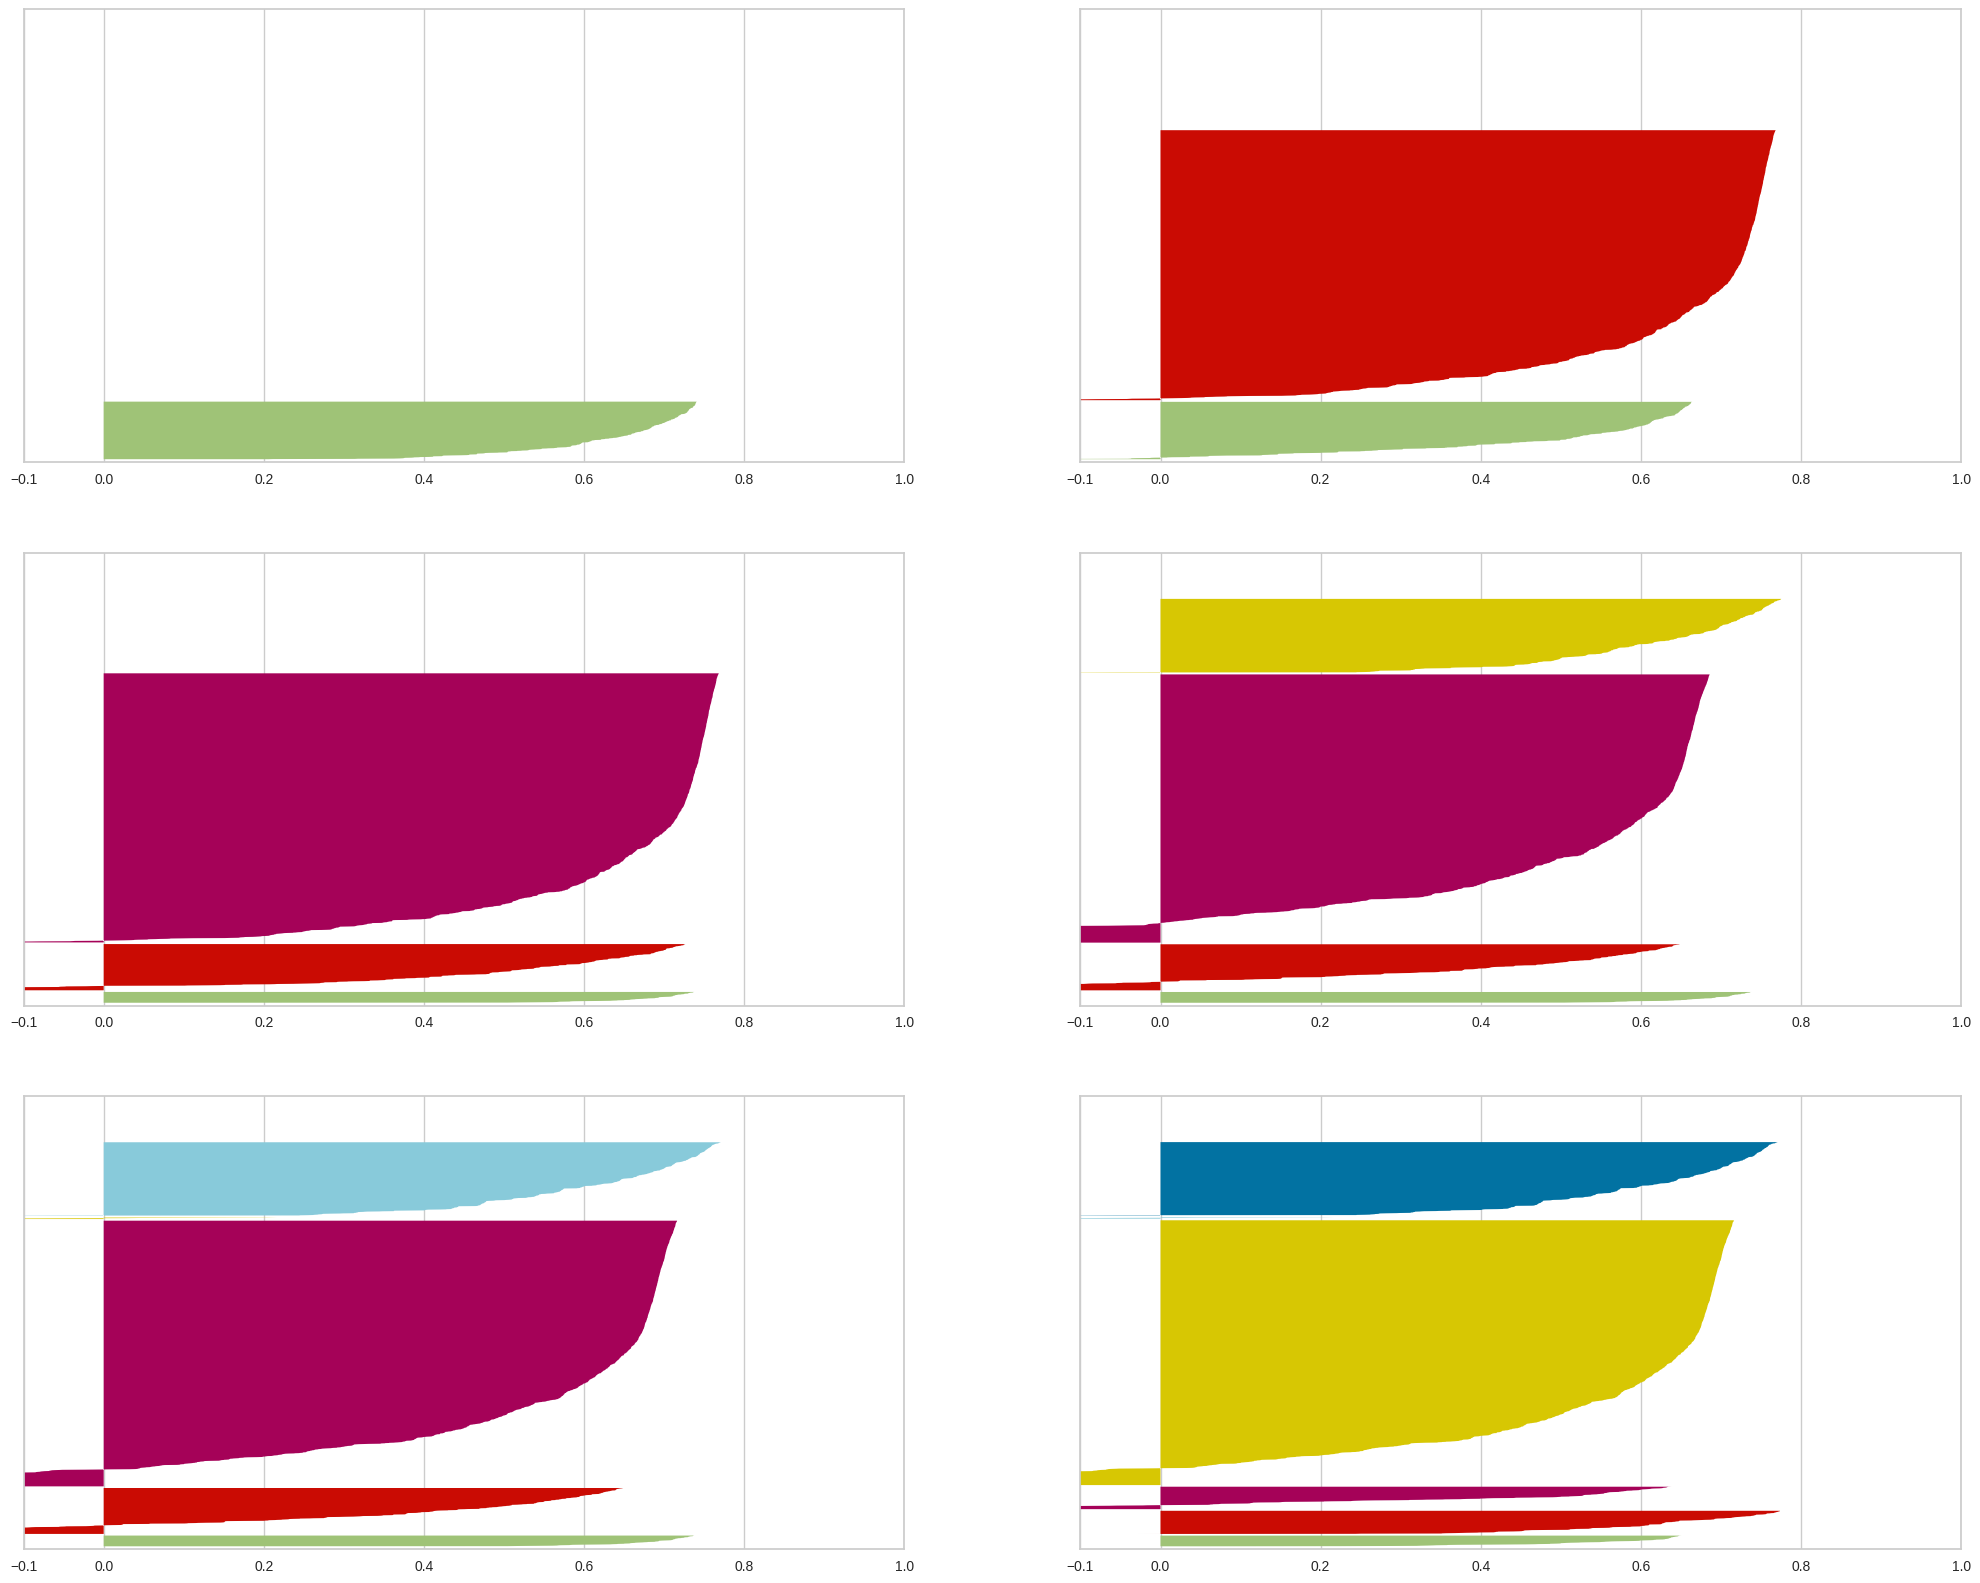

In [96]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    sils = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, sils ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## 8.0  Model Training

### 8.1 K-Means

In [129]:
# model definition
#k = 8
#kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
#kmeans.fit(X)

# clustering
#labels = kmeans.labels_

In [99]:
k=8
# model definition
kmeans = mx.GaussianMixture( n_components=k, n_init=300, random_state=32)

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

### 8.2 Cluster Validation

In [100]:
# WSS (Within-cluster Sum of Square)
#print( 'WSS value: {}'.format(kmeans.inertia_))

## SS (Silhoutte Score)
print( 'SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.6184369921684265


## 9.0 Cluster Analysis

In [101]:
X.head()

,embedding_x,embedding_y
0,21.462481,1.975596
1,18.213978,-2.484788
2,17.456253,19.114374
3,-1.531421,2.519522
4,6.208858,15.189176


In [102]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,21.462481,1.975596,5
1,18.213978,-2.484788,5
2,17.456253,19.114374,7
3,-1.531421,2.519522,6
4,6.208858,15.189176,4


### 9.1 Visualization Inspection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

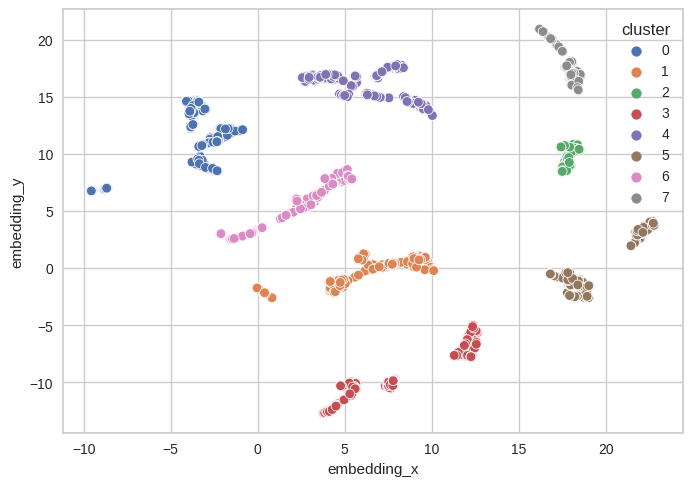

In [103]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

### 9.2 2d plot

In [104]:
#df_viz = df9.drop(columns='customer_id', axis=1)
# sns.pairplot(df_viz, hue='cluster')

### 9.3 UMAP

In [105]:
#reducer = umap.UMAP( n_neighbors=90, random_state=42)
#embedding = reducer.fit_transform(X)

# embedding
#df_viz['embedding_x'] = embedding[:,0]
#df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
#sns.scatterplot( x='embedding_x', y='embedding_y',
#                hue='cluster',
#                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
#                data=df_viz)

### 9.4 Cluster Profile

In [106]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,5
1,13047,3232.59,56.0,171.0,0.028302,35.0,5
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,6
4,15100,876.00,333.0,3.0,0.073171,22.0,4


In [108]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_products, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
7,7,255,8.591644,7760.927451,22.698039,336.725490,0.076508,81.882353
0,0,435,14.656334,6087.257057,80.349425,137.105747,0.147035,109.121839
2,2,176,5.929919,3900.387727,27.022727,229.409091,0.036884,36.562500
5,5,364,12.264151,2589.838654,40.629121,161.373626,0.085713,22.862637
3,3,432,14.555256,1769.042361,36.199074,118.895833,0.034697,22.085648
1,1,467,15.734501,1116.949893,66.447537,75.486081,0.072734,13.145610
6,6,368,12.398922,799.574755,76.122283,61.801630,0.087762,6.016304
4,4,471,15.869272,335.489214,118.690021,22.048832,0.287561,5.414013


In [109]:
# 7 Cluster Insiders
# 0 Cluster 
# 2 Cluster  
# 5 Cluster 
# 3 Cluster 
# 1 Cluster 
# 6 Cluster 
# 4 Cluster 

### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 467 (8.59% do customers )
    - Recência em média: 23 dias
    - Compras em média: 337 compras
    - Receita em  média: $7760,00 dólares
    - Ticket méito: $253,00 dólares
        
### Cluster 02: 
    - Número de customers: 28 (0.64% do customers )
    - Recência em média: 6 dias
    - Compras em média: 57 compras
    - Receita em média: $42.614,00 dólares
    - Ticket médio: $162,00 dólares
        
### Cluster 03: 
    - Número de customers: 267 (6,10% do customers )
    - Recência em média: 20 dias
    - Compras em média: 19 compras
    - Receita em média: $8.089,00 dólares
    - Ticket médio: $62,78 dólares

### Cluster 04: 
    - Número de customers: 4.071 (93,10% do customers )
    - Recência em média: 96 dias
    - Compras em média: 3 compras
    - Receita em média: $946,00 dólares
    - Ticket médio: $25,00 dólares

## 10.0 Análise Exploratória de Dados

In [110]:
df10 = df92.copy()

In [111]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,5
1,13047,3232.59,56.0,171.0,0.028302,35.0,5
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,6
4,15100,876.00,333.0,3.0,0.073171,22.0,4


### 10.1 MindMap de hipóteses

1. Fenomeno
2. Entidades (Customer, Location, Finance, Family)
3. Caracteristicas da Entidade (Customer=Nome, Idade, Sálario, Escolaridade)

### 10.2 Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

In [112]:
# Cluster |  Variável para testar  |  Base de comparação

## Hipóteses de Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes**
7. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do gmv pelos clientes insiders.**

### H1: **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
**Verdade:** O cluster insider possuem um volume de compra de produtos de 23.57%

In [113]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 7, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 23.57%


### H2. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
**Verdadeiro:** O cluster insider possuem um volume de GMV de 24.76%

In [114]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV Insiders: 24.76%


### H3. **Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes**
**Falso**: O cluser insiders tem a média de devoluções acima da média geral

In [115]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 7, 'qtde_returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['qtde_returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 82.0 vs Avg Return All:35.0


### H4. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a  mediana do faturamento geral.**
**Verdadeiro**. A mediana do faturamento é acima da média.

In [116]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 7, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 497.37%


### H5. **A GMV dos clientes insiders esta concentrados no 3 quartil**
**Falso**. O faturamento do cluster insiders está concentrada na quartil 1

In [118]:
np.percentile( df10.loc[df10['cluster'] == 7, 'gross_revenue'], q=0.1 )

767.53376

In [119]:
np.percentile( df10.loc[df10['cluster'] == 7, 'gross_revenue'], q=0.9 )

1829.4538400000001

<AxesSubplot: xlabel='gross_revenue'>

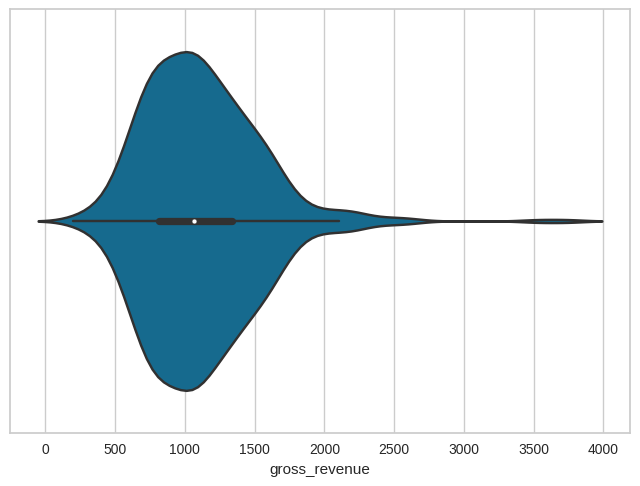

In [120]:
df_aux = df10.loc[(df10['cluster'] == 1) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];
sns.violinplot( x=df_aux )

## Hipóteses Cliente

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4.  5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

## Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

## Perguntas de Negócio

### **1. Quem são as pessoas elegíveis para participar do programa de Insiders ?**

In [121]:
df10.loc[df10['cluster'] == 7, 'customer_id'].head()

2     12583
6     14688
14    12431
20    13767
24    15513
Name: customer_id, dtype: int64

### **2. Quantos clientes farão parte do grupo?**

In [122]:
df10.loc[df10['cluster'] == 1, 'customer_id'].size

467

### 3. **Quais as principais características desses clientes ?**

#### Cluster Insider
    - Número de customers: 467 (8.59% do customers )
    - Faturamento médio: $ 7760,00
    - Recência média: 23 dias
    - Média de Produtos comprados: 337 produtos

### **4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**

In [125]:
df_insiders_gmv = df10.loc[df10['cluster'] == 7, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( 100*df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 24.755707144139905
